## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import BertTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from text_cleaning import *
from bert import CustomBert3
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
def get_site(url):
    return url.split('.')[0].split('/')[-1]

train['site'] = train['url'].apply(get_site)
code_site = train['site'].isin(['stackoverflow', 'codereview', 'superuser', 'programmers'])

train.loc[code_site, 'question_body'] = train.loc[code_site, 'question_body'].apply(replace_php_xml_code_to_tag)
train.loc[code_site, 'question_body'] = train.loc[code_site, 'question_body'].apply(replace_code_block)
train.loc[code_site, 'answer'] = train.loc[code_site, 'answer'].apply(replace_php_xml_code_to_tag)
train.loc[code_site, 'answer'] = train.loc[code_site, 'answer'].apply(replace_code_block)

test['site'] = test['url'].apply(get_site)
code_site = test['site'].isin(['stackoverflow', 'codereview', 'superuser', 'programmers'])

test.loc[code_site, 'question_body'] = test.loc[code_site, 'question_body'].apply(replace_php_xml_code_to_tag)
test.loc[code_site, 'question_body'] = test.loc[code_site, 'question_body'].apply(replace_code_block)
test.loc[code_site, 'answer'] = test.loc[code_site, 'answer'].apply(replace_php_xml_code_to_tag)
test.loc[code_site, 'answer'] = test.loc[code_site, 'answer'].apply(replace_code_block)

In [4]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.add_tokens([CODE_TOKEN, PHP_TOKEN])

seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



CPU times: user 29.6 s, sys: 221 ms, total: 29.8 s
Wall time: 30 s


In [5]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [8]:
num_workers = 10
bs = 2

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [10]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_7'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Wed Feb  5 19:29:54 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


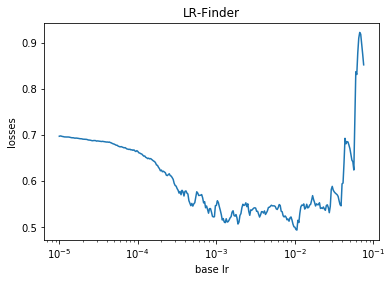

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50987 - spearmanr 0.2434
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47598 - spearmanr 0.37259
best model: epoch 0 - 0.37259
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45606 - spearmanr 0.3969
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46274 - spearmanr 0.39659
best model: epoch 1 - 0.39659
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43211 - spearmanr 0.46019
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4584 - spearmanr 0.40089
best model: epoch 2 - 0.40089
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41032 - spearmanr 0.5144
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46104 - spearmanr 0.40256
best model: epoch 3 - 0.40256
TRAINING END: Best score achieved on epoch 3 - 0.40256
Starting inference for model: checkpoints/siamese_bert_7_fold_1_best.pth



Averaged Val. score: 0.4025609383037244
Starting inference for model: checkpoints/siamese_bert_7_fold_1_best.pth



Fold 2 started at Wed Feb  5 20:10:30 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50863 - spearmanr 0.24735
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46897 - spearmanr 0.364
best model: epoch 0 - 0.364
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45581 - spearmanr 0.39757
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4563 - spearmanr 0.39143
best model: epoch 1 - 0.39143
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43228 - spearmanr 0.46086
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4602 - spearmanr 0.38747
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41043 - spearmanr 0.51585
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46031 - spearmanr 0.39129
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39143
Starting inference for model: checkpoints/siamese_bert_7_fold_2_best.pth



Averaged Val. score: 0.3914336384109883
Starting inference for model: checkpoints/siamese_bert_7_fold_2_best.pth



Fold 3 started at Wed Feb  5 20:50:02 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50924 - spearmanr 0.24732
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46093 - spearmanr 0.38152


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38152
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4569 - spearmanr 0.39563
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45044 - spearmanr 0.40072
best model: epoch 1 - 0.40072
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43305 - spearmanr 0.45983
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44713 - spearmanr 0.40944
best model: epoch 2 - 0.40944
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41139 - spearmanr 0.51266
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44987 - spearmanr 0.41127
best model: epoch 3 - 0.41127
TRAINING END: Best score achieved on epoch 3 - 0.41127
Starting inference for model: checkpoints/siamese_bert_7_fold_3_best.pth



Averaged Val. score: 0.41127222442511346
Starting inference for model: checkpoints/siamese_bert_7_fold_3_best.pth



Fold 4 started at Wed Feb  5 21:29:24 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50939 - spearmanr 0.24395
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47298 - spearmanr 0.39264
best model: epoch 0 - 0.39264
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45567 - spearmanr 0.39367
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45799 - spearmanr 0.42517
best model: epoch 1 - 0.42517
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43146 - spearmanr 0.45942
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45896 - spearmanr 0.42652
best model: epoch 2 - 0.42652
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40995 - spearmanr 0.51229
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46243 - spearmanr 0.42562
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42652
Starting inference for model: checkpoints/siamese_bert_7_fold_4_best.pth



Averaged Val. score: 0.4265204941204511
Starting inference for model: checkpoints/siamese_bert_7_fold_4_best.pth



Fold 5 started at Wed Feb  5 22:08:29 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50995 - spearmanr 0.24469
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46863 - spearmanr 0.36399
best model: epoch 0 - 0.36399
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45607 - spearmanr 0.39707
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46048 - spearmanr 0.38617
best model: epoch 1 - 0.38617
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43156 - spearmanr 0.46118
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45649 - spearmanr 0.39641
best model: epoch 2 - 0.39641
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41058 - spearmanr 0.51395
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46127 - spearmanr 0.39573
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39641
Starting inference for model: checkpoints/siamese_bert_7_fold_5_best.pth



Averaged Val. score: 0.3964090138764097
Starting inference for model: checkpoints/siamese_bert_7_fold_5_best.pth



Fold 6 started at Wed Feb  5 22:47:48 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50753 - spearmanr 0.25237
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47468 - spearmanr 0.38304
best model: epoch 0 - 0.38304
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45569 - spearmanr 0.39688
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45997 - spearmanr 0.40258
best model: epoch 1 - 0.40258
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43197 - spearmanr 0.46061
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45625 - spearmanr 0.41011
best model: epoch 2 - 0.41011
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41019 - spearmanr 0.51514
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45948 - spearmanr 0.40824
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41011
Starting inference for model: checkpoints/siamese_bert_7_fold_6_best.pth



Averaged Val. score: 0.4101098954822609
Starting inference for model: checkpoints/siamese_bert_7_fold_6_best.pth



Fold 7 started at Wed Feb  5 23:27:34 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50993 - spearmanr 0.24265
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46477 - spearmanr 0.3992
best model: epoch 0 - 0.3992
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45683 - spearmanr 0.39325
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45153 - spearmanr 0.41196
best model: epoch 1 - 0.41196
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43332 - spearmanr 0.45647
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44792 - spearmanr 0.42521
best model: epoch 2 - 0.42521
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4118 - spearmanr 0.51045
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44973 - spearmanr 0.42408
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42521
Starting inference for model: checkpoints/siamese_bert_7_fold_7_best.pth



Averaged Val. score: 0.42521284019234007
Starting inference for model: checkpoints/siamese_bert_7_fold_7_best.pth



Fold 8 started at Thu Feb  6 00:06:46 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50899 - spearmanr 0.24564
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.4682 - spearmanr 0.3793
best model: epoch 0 - 0.3793
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45639 - spearmanr 0.39439
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45147 - spearmanr 0.41679
best model: epoch 1 - 0.41679
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43241 - spearmanr 0.45955
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45037 - spearmanr 0.41985
best model: epoch 2 - 0.41985
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41085 - spearmanr 0.51393
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45069 - spearmanr 0.42228
best model: epoch 3 - 0.42228
TRAINING END: Best score achieved on epoch 3 - 0.42228
Starting inference for model: checkpoints/siamese_bert_7_fold_8_best.pth



Averaged Val. score: 0.4222842062168504
Starting inference for model: checkpoints/siamese_bert_7_fold_8_best.pth



Fold 9 started at Thu Feb  6 00:45:29 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5092 - spearmanr 0.24411
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.469 - spearmanr 0.37653
best model: epoch 0 - 0.37653
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45623 - spearmanr 0.3953
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45808 - spearmanr 0.40046
best model: epoch 1 - 0.40046
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43208 - spearmanr 0.46032
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45633 - spearmanr 0.40629
best model: epoch 2 - 0.40629
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4106 - spearmanr 0.51392
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45813 - spearmanr 0.40767
best model: epoch 3 - 0.40767
TRAINING END: Best score achieved on epoch 3 - 0.40767
Starting inference for model: checkpoints/siamese_bert_7_fold_9_best.pth



Averaged Val. score: 0.4076716072858887
Starting inference for model: checkpoints/siamese_bert_7_fold_9_best.pth



Fold 10 started at Thu Feb  6 01:24:14 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50886 - spearmanr 0.24708
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46556 - spearmanr 0.37478
best model: epoch 0 - 0.37478
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45632 - spearmanr 0.39718
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45916 - spearmanr 0.39947
best model: epoch 1 - 0.39947
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4321 - spearmanr 0.46129
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45441 - spearmanr 0.40685
best model: epoch 2 - 0.40685
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4106 - spearmanr 0.51414
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45535 - spearmanr 0.40714
best model: epoch 3 - 0.40714
TRAINING END: Best score achieved on epoch 3 - 0.40714
Starting inference for model: checkpoints/siamese_bert_7_fold_10_best.pth



Averaged Val. score: 0.40714223417981626
Starting inference for model: checkpoints/siamese_bert_7_fold_10_best.pth



OOF score: 0.4089546043647215


In [12]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1], head_dropout=0.2)
    model.bert.resize_token_embeddings(len(tokenizer))
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))
#     scheduler = transformers.get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=2736, num_training_steps=n_epochs*2736+1)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [13]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4883568697408671
5 4 0.462551591548189
9 16 0.1151604452768644
11 8 0.7499806143111364
12 4 0.5132413137564469
13 16 0.22375477730609852
14 4 0.6070637212792913
15 4 0.5452713020405877
16 16 0.7858178917293239
19 32 0.11584276822173094


In [14]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 16,  8,  4, 16,  4,  4, 16, 32]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19]))

In [15]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [16]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.408955
CV unique rows,0.370638
CV ignoring hard targets,0.432525
CV unique rows ignoring hard targets,0.391326
CV w rounding,0.434478
CV unique rows w rounding,0.412646
CV ignoring hard targets w rounding,0.457262
CV unique rows ignoring hard targets w rounding,0.423880


In [17]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.412999
CV unique rows,0.374722
CV ignoring hard targets,0.432525
CV unique rows ignoring hard targets,0.391326
CV w rounding,0.436799
CV unique rows w rounding,0.412646
CV ignoring hard targets w rounding,0.457262
CV unique rows ignoring hard targets w rounding,0.423880


In [18]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [19]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.824172,0.598184,0.401538,0.407225,0.520474,0.331666,0.703793,0.718821,0.715629,0.004636,0.708193,0.776433,0.035015,0.452399,0.009394,0.013378,0.079634,0.147920,0.742430,0.001164,0.825359,0.566590,0.185107,0.732682,0.703898,0.305651,0.022018,0.038215,0.769825,0.628926
1,46,0.464249,0.301089,0.009433,0.697842,0.659486,0.878936,0.420024,0.346157,0.064435,0.013354,0.458164,0.286583,0.005108,0.000657,0.000924,0.011555,0.884732,0.327104,0.073873,0.000150,0.240312,0.788374,0.483641,0.869512,0.926298,0.591838,0.946144,0.215132,0.049168,0.612228
2,70,0.645448,0.473095,0.042536,0.630193,0.813778,0.896376,0.486971,0.405041,0.369787,0.004929,0.299480,0.746060,0.034920,0.067654,0.002618,0.006480,0.178745,0.175074,0.740079,0.000796,0.612754,0.669823,0.312818,0.822617,0.818086,0.467743,0.056174,0.077471,0.824232,0.560824
3,132,0.542306,0.177266,0.004970,0.602016,0.654006,0.869717,0.379783,0.239177,0.206835,0.010397,0.574880,0.132872,0.002594,0.003559,0.000565,0.002967,0.813778,0.328829,0.637650,0.000080,0.403572,0.794600,0.600391,0.849552,0.899584,0.635204,0.837142,0.343343,0.641923,0.679581
4,200,0.780688,0.269349,0.048256,0.808248,0.714831,0.856477,0.678922,0.701297,0.225870,0.027078,0.361390,0.601207,0.011306,0.021910,0.013459,0.070010,0.171551,0.201891,0.549401,0.004342,0.352271,0.736065,0.537613,0.868748,0.866415,0.618695,0.226988,0.238372,0.684867,0.611296


In [20]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [21]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.819275,0.637370,0.200303,0.567963,0.597360,0.434717,0.629057,0.537747,0.514903,0.003215,0.702837,0.549608,0.466940,0.082821,0.018765,0.090343,0.226301,0.167940,0.536051,0.004284,0.730111,0.807799,0.562762,0.925186,0.901953,0.646579,0.190183,0.146259,0.825130,0.711199
1,0.852632,0.775150,0.066967,0.646966,0.897638,0.675100,0.518005,0.668884,0.462616,0.003130,0.274600,0.168959,0.813121,0.012960,0.774850,0.153992,0.037977,0.063613,0.331402,0.018750,0.657695,0.661193,0.429081,0.816602,0.780476,0.424606,0.027006,0.048904,0.527824,0.726037
2,0.628548,0.223850,0.010447,0.799741,0.744780,0.870812,0.503726,0.346828,0.156657,0.001968,0.419910,0.518234,0.003925,0.001599,0.000650,0.451343,0.581282,0.214099,0.076651,0.000079,0.555270,0.888498,0.636731,0.929335,0.912231,0.723538,0.595354,0.214119,0.359241,0.774163
3,0.786205,0.732747,0.389739,0.820917,0.639891,0.747559,0.603709,0.633167,0.111640,0.004817,0.456035,0.964044,0.008151,0.009446,0.008041,0.009283,0.022749,0.124854,0.494044,0.000838,0.872044,0.763157,0.800816,0.713576,0.894453,0.716922,0.015756,0.293442,0.911439,0.736537
4,0.842580,0.737431,0.001907,0.732820,0.861793,0.932378,0.549795,0.545561,0.304743,0.000208,0.256144,0.656953,0.000760,0.000441,0.000995,0.002938,0.845560,0.283075,0.148216,0.000098,0.855115,0.776372,0.418226,0.864930,0.892166,0.624688,0.913168,0.201519,0.040973,0.606178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.820909,0.281765,0.226705,0.873503,0.661733,0.637768,0.655063,0.665440,0.457094,0.002358,0.491959,0.862621,0.193803,0.056176,0.018444,0.217337,0.009444,0.031715,0.552713,0.002754,0.606472,0.790595,0.666347,0.863672,0.851705,0.642188,0.043204,0.093871,0.871197,0.705212
6075,0.885717,0.467305,0.123438,0.499771,0.480949,0.328121,0.750795,0.784171,0.126119,0.008341,0.791512,0.033497,0.041941,0.012319,0.003264,0.023609,0.745456,0.423027,0.285406,0.000704,0.724393,0.777876,0.592539,0.916727,0.906822,0.624332,0.681219,0.411475,0.518869,0.835164
6076,0.602056,0.223335,0.001593,0.700558,0.713356,0.921040,0.358521,0.214713,0.118876,0.001164,0.460445,0.403006,0.000744,0.000481,0.000293,0.000566,0.828683,0.362695,0.241086,0.000015,0.345149,0.375561,0.270569,0.555459,0.530378,0.289581,0.646582,0.290754,0.401471,0.085287
6077,0.829275,0.441667,0.508603,0.165208,0.364031,0.140159,0.653184,0.801472,0.883544,0.001290,0.834387,0.666908,0.202922,0.109513,0.012044,0.031544,0.038492,0.154231,0.733693,0.000130,0.828723,0.699189,0.372228,0.834675,0.853369,0.445628,0.023896,0.090028,0.849038,0.805050


In [22]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.383214
question_body_critical                   0.660191
question_conversational                  0.413543
question_expect_short_answer             0.302009
question_fact_seeking                    0.359955
question_has_commonly_accepted_answer    0.430946
question_interestingness_others          0.349578
question_interestingness_self            0.513307
question_multi_intent                    0.583086
question_not_really_a_question           0.093791
question_opinion_seeking                 0.473096
question_type_choice                     0.739126
question_type_compare                    0.348515
question_type_consequence                0.170738
question_type_definition                 0.360039
question_type_entity                     0.437312
question_type_instructions               0.783187
question_type_procedure                  0.365696
question_type_reason_explanation         0.671293
question_type_spelling                   0.064157


In [23]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.064157,3.0
question_not_really_a_question,0.093791,5.0
answer_plausible,0.137470,9.0
answer_relevance,0.152226,9.0
question_type_consequence,0.170738,5.0
answer_well_written,0.220272,9.0
answer_helpful,0.238993,9.0
question_expect_short_answer,0.302009,5.0
answer_type_procedure,0.309612,5.0
answer_satisfaction,0.326116,17.0


In [24]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

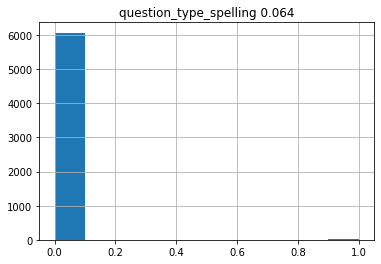

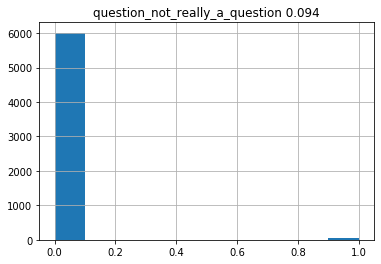

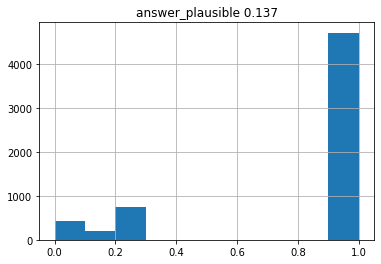

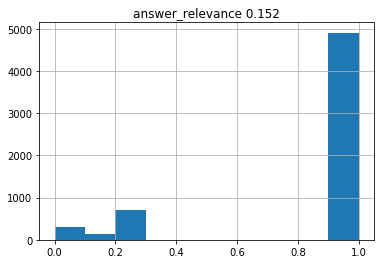

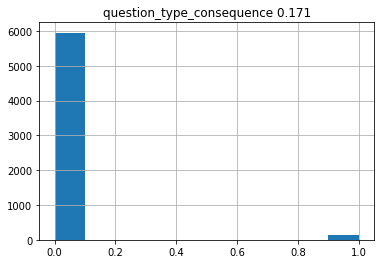

In [25]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


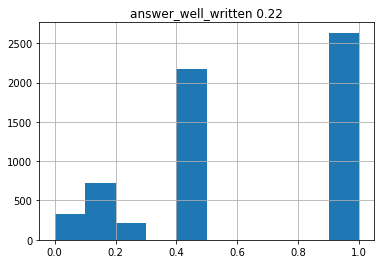

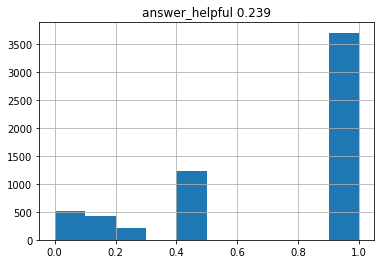

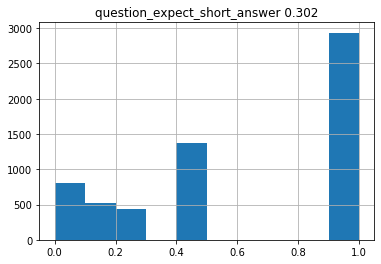

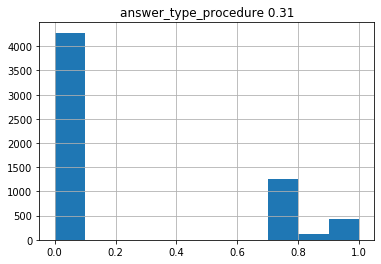

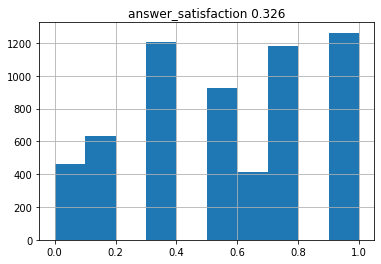

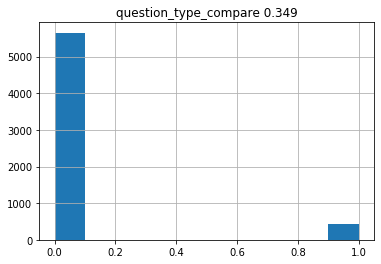

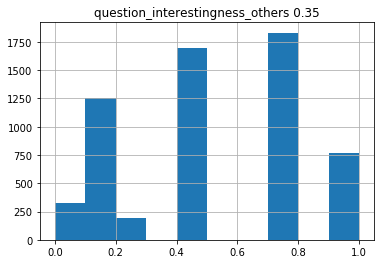

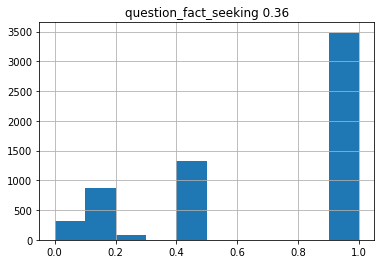

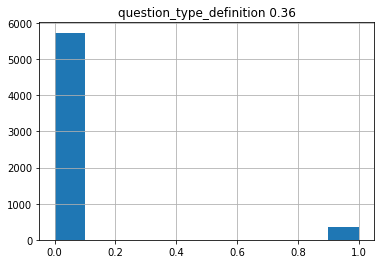

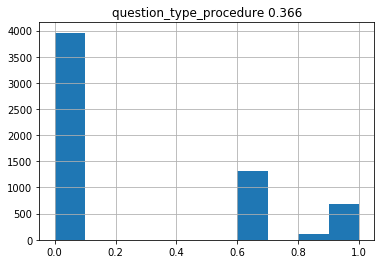

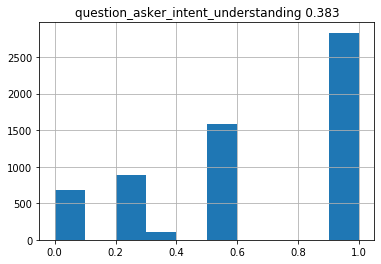

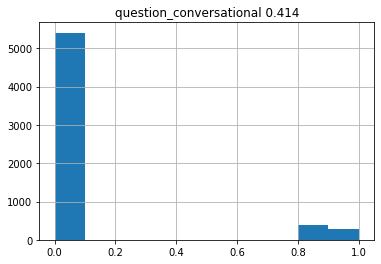

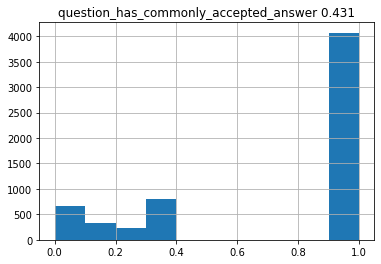

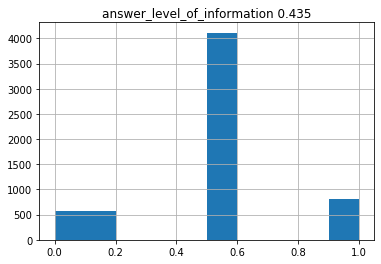

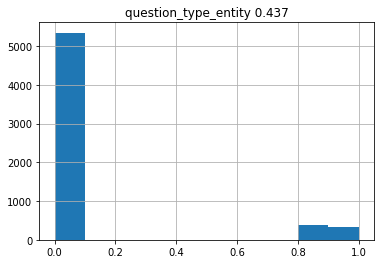

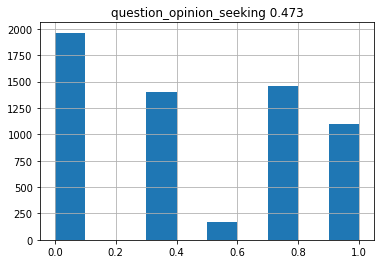

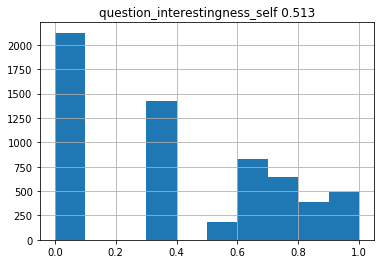

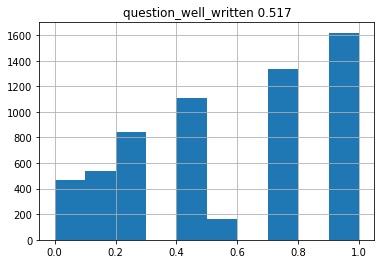

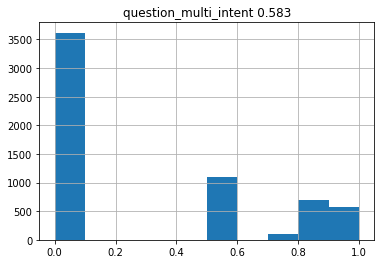

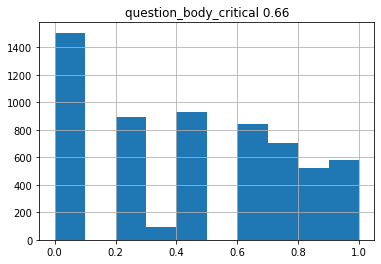

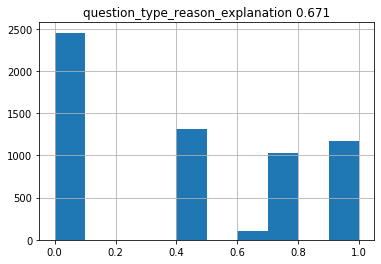

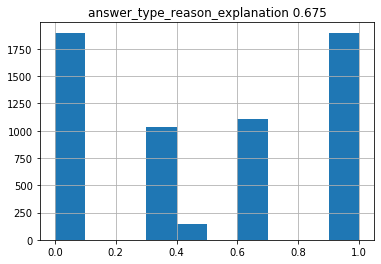

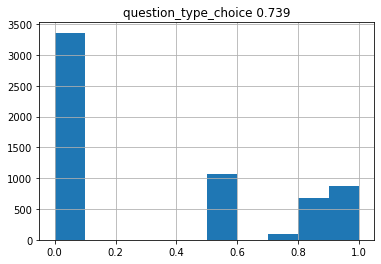

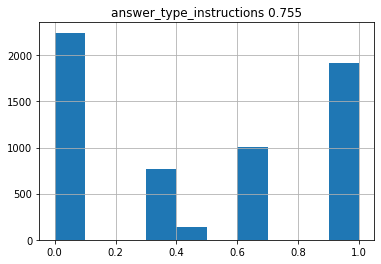

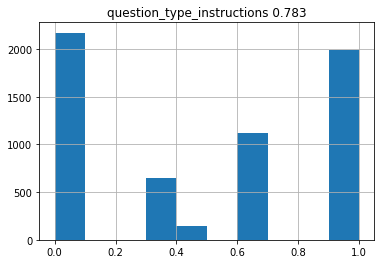

In [26]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')